[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Jacky-lim-data-analyst/mini_project_cv/blob/main/w6_tutorial.ipynb)

# Learning outcomes
1. Image thresholding techniques
    * Otsu thresholding
2. Convolution operation in image
    * Sharpening
    * Blurring
3. Edge detection
4. Contour

# Setup

In [2]:
import sys
assert sys.version_info >= (3, 8)

import cv2 as cv
import numpy as np

if cv.useOptimized():
    cv.setUseOptimized(True)

cv.useOptimized()

True

# Thresholding
Image thresholding is used to separate an image into foreground and background regions. It involves selecting a threshold value that partitions the image pixels into 2 classes. For example, those above the threshold are considered foreground, while those below are considered background.

## Global thresholding
Select a single threshold value based on the overall image histogram. The function is as shown:
```{python}
cv.threshold(src, thresh, maxval, type)
```
1. `src`: input image
2. `thresh`: threshold value (pixel intensity)
3. `maxval`: maximum value to be use with binary thresholding
4. `type`: threshold flags.

You can refer to the [online documentation](https://docs.opencv.org/4.x/d7/d1b/group__imgproc__misc.html#ggaa9e58d2860d4afa658ef70a9b1115576a147222a96556ebc1d948b372bcd7ac59) for more info about the threshold flags.

## Applications of image thresholding
1. Image segmentation: separate objects of interest from background.
2. Document image analysis: Binarize scanned document for Optical character recognition (OCR)
3. Defect detection in manufactured parts

In [2]:
# show the flags of thresholding mode
flags = [i for i in dir(cv) if i.startswith("THRESH")]

In [3]:
print(flags)

['THRESH_BINARY', 'THRESH_BINARY_INV', 'THRESH_MASK', 'THRESH_OTSU', 'THRESH_TOZERO', 'THRESH_TOZERO_INV', 'THRESH_TRIANGLE', 'THRESH_TRUNC']


In [4]:
img = np.fromfunction(lambda i, j: j, (50, 256), dtype=np.uint8)

def trackbar(x):
    _, img1 = cv.threshold(img, x, 255, cv.THRESH_BINARY)
    _, img2 = cv.threshold(img, x, 255, cv.THRESH_BINARY_INV)
    _, img3 = cv.threshold(img, x, 255, cv.THRESH_TRUNC)
    _, img4 = cv.threshold(img, x, 255, cv.THRESH_TOZERO)
    _, img5 = cv.threshold(img, x, 255, cv.THRESH_TOZERO_INV)

    cv.imshow('window', np.vstack([img1, img2, img3, img4, img5]))

cv.namedWindow('window')
cv.createTrackbar('threshold', 'window', 100, 255, trackbar)

cv.waitKey(0)
cv.destroyAllWindows()

### Otsu binarization
In global thresholding, we used an arbitrary chosen value as a threshold. In contrast, Otsu's method avoids having to choose a value and determines it automatically. 

Consider an image with only 2 distinct image values (*bimodal image*), where the histogram would only consists of 2 peaks. A good threshold would be to select value in the middle of those 2 values. Similarly, Otsu's method determines an optimal global threshold value from the histogram.

In order to do so, the `cv.threshold()` function is used, where `cv.THRESH_OTSU` is passed as an extra flag. 

In [5]:
import matplotlib.pyplot as plt

In [6]:
gray = cv.imread("images/noisy.jfif", 0)

# global threshold
ret, th1 = cv.threshold(gray, 127, 255, cv.THRESH_BINARY)

# Otsu threshold
ret, th2 = cv.threshold(gray, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)

# Gaussian blur + Otsu threshold
blur = cv.GaussianBlur(gray, (5, 5), 0)
ret, th3 = cv.threshold(blur, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)

# Plot grayscale images, their histogram and the resulting thresholded image
images = [gray, None, th1,
         gray, None, th2,
         blur, None, th3]

titles = ["Original noisy image", "histogram", "global threshold",
         "Original noisy image", "histogram", "Otsu threshold",
         "Smoothed image", "histogram", "Otsu threshold"]

plt.figure(figsize=(12, 12))
for i in range(3):
    plt.subplot(3, 3, 3*i + 1), plt.imshow(images[3*i], cmap="gray", vmin=0, vmax=255)
    plt.title(titles[3*i]), plt.axis("off")
    plt.subplot(3, 3, 3*i + 2), plt.hist(images[3*i].ravel(), 256)
    plt.title(titles[3*i+1])
    plt.subplot(3, 3, 3*i + 3), plt.imshow(images[3*i + 2], cmap="gray", vmin=0, vmax=255)
    plt.title(titles[3*i+2]), plt.axis("off")

plt.show()

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\smooth.dispatch.cpp:617: error: (-215:Assertion failed) !_src.empty() in function 'cv::GaussianBlur'


### Exercise
* Can you segment the leaf from the image "leaf.jpg"?

In [11]:
image = cv.imread('leaf.jpg')
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

# Apply a Gaussian blur to the grayscale image to reduce noise
blurred = cv.GaussianBlur(gray, (5, 5), 0)

# Apply a binary threshold to get a binary image
# You might need to adjust the threshold value (e.g., 127) depending on your image
_, binary = cv.threshold(blurred, 127, 255, cv.THRESH_BINARY)

# Find contours in the binary image
contours, _ = cv.findContours(binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Create an empty mask to draw the contours
mask = np.zeros_like(gray)

# Draw the contours on the mask
cv.drawContours(mask, contours, -1, (255), thickness=cv.FILLED)

# Apply the mask to the original image
segmented = cv.bitwise_and(image, image, mask=mask)

# Display the result
cv.imshow('Original Image', image)
cv.imshow('Binary Image', binary)
cv.imshow('Segmented Leaf', segmented)
cv.waitKey(0)
cv.destroyAllWindows()


# Introduction of convolution in image processing
In image processing, a convolution kernel is a 2D matrix that is used to filter images. A convolution kernel is typically a square matrix, $M \times N$, where both _M_ and _N_ are odd integers. An example of averaging kernel:  
$kernel = \frac{1}{9}\begin {bmatrix}
1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1 \\
\end {bmatrix}$  
A $ 3 \times 3 $ 2D convolution kernel.

Such kernel can be used to perform mathematical operations on each pixel of an image to achieve a desired effect (like blurring or sharpening an image). Check out this [video](https://www.youtube.com/watch?v=8rrHTtUzyZA) for more interactive examples and elaborations on the concepts of convolution.

But why would you want to blur an image? Here are 2 reasons:
* Because it reduces noise in an image.
* To remove a distinct background.

The value of individual elements in a kernel dictate the nature of filtering. For example, by changing the value of the kernel elements, you can also achieve sharpening effect.

## Convolution in action
![convolution](img_embed/2D_Convolution_Animation.gif "Source: https://commons.wikimedia.org/wiki/File:2D_Convolution_Animation.gif")

## 2D convolution
As in one-dimensional signals, images also can be filtered with various low-pass filters (LPF), high-pass filters (HPF) and etc. LPF helps in removing noise, blurring images, etc. HPF filters help in finding edges in images, which is also equivalent to original image minus the low-pass filtered image.

OpenCV provides a function `cv.filter2D()` to convolve a kernel with an image. 
```python
cv.filter2D(src, ddepth, kernel, ...)
```
1. The first argument, src is source image.
2. ddepth indicates the depth of the resulting image. We will normally set it as -1 so that the final image will have the same depth as the source image, src.
3. kernel is the convolution matrix
4. To know more about optional argument `borderType`, please refer to this [link](https://docs.opencv.org/4.5.5/d2/de8/group__core__array.html#ga209f2f4869e304c82d07739337eae7c5).

In [12]:
from utils import display_images
# Identity kernel
img = cv.imread('camera.jpg')

kernel = np.zeros((3, 3), dtype=np.uint8)
kernel[1, 1] = 1

identity = cv.filter2D(img, -1, kernel)

display_images([img, identity], ("original", "identity"))

In [9]:
# Blurring with mean filtering
kernel = np.ones((5, 5), dtype=np.float32) / 25
dst = cv.filter2D(img, -1, kernel)

display_images([img, dst], ("original", "blurred"))

### Other function to smooth images
Image blurring is achieved by convolving the image with a low-pass filter kernel. It is useful for removing noise, yet it also removes high frequency content (e.g. noise, edges) from the image. So edges are blurred a little bit in this operation (there are also blurring techniques which don't blur the edges). OpenCV provides four main types of blurring techniques.

1. Averaging. This is done by the function `cv.blur()` or `cv.boxFilter()`. We will use `cv.blur()` in the following example.
```python
cv.blur(src, ksize)
```
1. The first argument is the source image.
2. The second argument is the blurring kernel size. ($width, height$)

In [13]:
blur = cv.blur(img, (5, 5))

display_images([img, blur], ("original", "blur"))

2. Gaussian Blurring. This is done by `cv.GaussianBlur()`. We should specify the width and height of the kernel which should be positive and odd. We should also specify the standard deviation in the X and Y directions, sigmaX and sigmaY respectively. Better at preserving edges, but slower compared to its average counterparts
```python
cv.GaussianBlur(src, ksize, sigmaX, sigmaY, ...)
```

- First argument, src is the source image.
- ksize is the Gaussian kernel size ($width, height$)
- sigmaX is the Gaussian kernel standard deviation in X direction. 
- sigmaY is the Gaussian kernel standard deviation in Y direction. If sigmaY is set to zero, it is set to be equal to sigmaX. If both sigmaX and sigmaY are zero, then they are computed from ksize.width and ksize.height. Please refer to the [online documentation](https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#gaabe8c836e97159a9193fb0b11ac52cf1) for more details.

3. Median Blurring. This is done by `cv.medianBlur()`. Best in removing salt and pepper noise. 

4. Bilateral filtering. This is done by `cv.bilateralFilter()`. It is highly effective in noise removal while keeping edges sharp. But the operation is slower compared to other filters. 
    - Bilateral filtering takes a Gaussian filter in space, but one more Gaussian filter which is a function of pixel difference. The Gaussian function of space makes sure that only nearby pixels are considered for blurring, while Gaussian function of intensity difference ensures that only those pixels with similar intensities are considered for blurring.

### Image sharpening by convolutional kernel
The sharpening kernel emphasizes differences in adjacent pixel values, making the whole image looks more vivid. The algorithm for sharpening an image is:
1. Blur an image using arbitrary kernel you wish.
2. Subtract the blurred image from the original image to get high frequency details. 
3. Add the high-frequency details to the original image.

Source: [Blog post](https://blog.demofox.org/2022/02/26/image-sharpening-convolution-kernels/)

In [14]:
kernel = np.array([[0, -1, 0],
                  [-1, 5, -1],
                  [0, -1, 0]])

img = cv.imread('meal.jpg')
sharp_img = cv.filter2D(img, -1, kernel)

display_images([img, sharp_img], ("original", "sharpen"))

## Emboss filter
The emboss filter is a popular image processing technique that generates a 3D, raised effect by manipulating pixel values based on local contrast and brightness differences.

In [16]:
from utils import display_images

kernel = np.array([[-2, -1, 0],
                  [-1, 1, 1],
                  [0, 1, 2]])

img = cv.imread("car.jpg")
emboss_img = cv.filter2D(img, -1, kernel)
display_images([img, emboss_img], ("original", "emboss"))

#### Exercise
- Apply average kernel with increasing size on an image. Use "dog.jfif" for this exercise. What can you infer from the output images.

# Edge detection
Consider an image, how can we find the salient edges? Qualitatively, edges occur at boundaries between regions of different color, intensity or texture. Often, it is preferable to detect edges using only purely local information.

Edges are characterized by sudden change in pixel intensity. To detect edges, we need to look for such changes in the neighboring pixels. You can easily notice that in an edge the pixel intensity changes in a notorious way. A good way to express changes is by using derivatives. A high change in gradient indicates a major change in the image. 

The method to detect edges can be performed by locating pixel locations where the gradient is higher than its neighbors (or to generalize, higher than a threshold). A Sobel operator is a discrete differentiation operator. It computes an approximation of the gradient of an image intensity function. The Sobel operator combines Gaussian smoothing and differentiation.

## Image Gradients

OpenCV provides 3 types of gradient filters or HPF: Sobel, Scharr and Laplacian. 

1. Sobel and Scharr Derivatives  
Sobel operators is a joint Gaussian smoothing plus differentiation operation, so it is more resistant to noise. You can specify the direction of derivatives to be taken, vertical or horizontal (by the arguments, yorder and xorder respectively). When applying Sobel operator for edge detection, we need to convert the color image to grayscale image. If you want to apply Scharr derivatives, you can set `ksize` to be -1.

$$Sobel_x = \begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix}$$

$$Sobel_y = \begin{bmatrix} 1 & 2 & 1 \\ 0 & 0 & 0 \\ -1 & -2 & -1 \end{bmatrix}$$

$$Scharr_x = \begin{bmatrix} 3 & 0 & -3 \\ 10 & 0 & -10 \\ 3 & 0 & -3 \end{bmatrix}$$

$$Scharr_y = \begin{bmatrix} 3 & 10 & 3 \\ 0 & 0 & 0 \\ -3 & -10 & -3 \end{bmatrix}$$

3. Laplacian Derivatives. One such example is as shown below:
$$kernel= \begin{bmatrix} 0 & -1 & 0 \\ -1 & 4 & -1 \\ 0 & -1 & 0 \end{bmatrix}$$

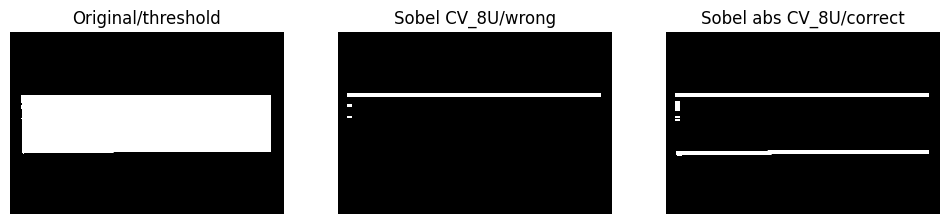

In [20]:
img = cv.imread("wood_planck.jfif")
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

ret, img_wood = cv.threshold(gray, 200, 255, cv.THRESH_BINARY_INV)

# output dtype = cv.CV_8U
# detect horizontal edges
sobely8u = cv.Sobel(img_wood, cv.CV_8U, 0, 1, ksize=5)

# set output type as cv.CV_64F
sobely64f = cv.Sobel(img_wood, cv.CV_64F, 0, 1, ksize=5)
sobely_8u = cv.convertScaleAbs(sobely64f)

from utils import matplotlib_show_images
matplotlib_show_images([img_wood, sobely8u, sobely_8u], 1, 3, 
                      titles=["Original/threshold", "Sobel CV_8U/wrong", "Sobel abs CV_8U/correct"],
                      figsize=(12, 4))

In [21]:
#Comparison betweeen LoG  and Sobel x and y operator
img = cv.imread("camera.jpg", 0)

laplacian = cv.Laplacian(img, cv.CV_64F, ksize=3)
laplacian = cv.convertScaleAbs(laplacian)
sobelx = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=3)
sobelx = cv.convertScaleAbs(sobelx)
sobely = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=3)
sobely = cv.convertScaleAbs(sobely)

from utils import display_images

display_images([laplacian, sobelx, sobely], 
               ("laplacian", "Sobel x", "Sobel y"))

In [19]:
blur = cv.GaussianBlur(img, (5, 5), 0)

laplacian_gaussian = cv.Laplacian(blur, cv.CV_64F, ksize=3)
laplacian_gaussian = cv.convertScaleAbs(laplacian_gaussian)

display_images([laplacian, laplacian_gaussian], ("laplacian", "laplacian blur"))

## Exercise
1. Use convolution `cv.filter2D()` to implement Laplacian filter on 'lena.jfif'.
2. What happen if you add the results of Laplacian of Gaussian (LOG) filters into the original image.

## Canny Edge Detection

1. **Noise Reduction**  
Since edge detection is susceptible to noise in the image, the first step is to remove noise using 5x5 Gaussian filter.

2. **Finding Intensity Gradient of the image**. Sobel operators x and y are utilized.

3. **Non-maximum Suppression** is to filter out unwanted pixels (which do not constitute valid edges). To accomplish that, each pixel is compared to its neighboring pixels, in the positive and negative gradient direction. If the gradient magnitude of the current pixel is greater than its neighboring pixels, it is left unchanged. Otherwise, the magnitude of the current pixel is set to zero. 

4. **Hysterisis thresholding**. The gradient magnitude are compared with the 2 threshold values.

### Canny edge detection in OpenCV
OpenCV puts all the above in single function, `cv.Canny()`. 
```python
# The 4th and 5th arguments are optional.
cv.Canny(img, threshold1, threshold2, apertureSize=3, L2gradient = False)
```
* First argument is input image.
* Second and third arguments are minVal and maxVal respectively.
* Fouth argument is aperture size, which is the size of Sobel operator used to find gradients. Default is 3.
* Last argument is L2 gradient which specifies the equation to find the gradient magnitude. It can be `True` or `False`.

In [25]:
img = cv.imread("camera.jpg", 0)

edges = cv.Canny(img, 100, 300)
display_images([img, edges], ("original", "edges map"))

Generally speaking, Canny edge detection produces the best results in most applications because it provides more flexibility in how edges are identified and connected.

### Zero-parameter / automatic Canny edge detector
From the examples above, we know that `threshold1` and `threshold2` are two of the most crucial parameters to control the quality of edge detection results. This begs a question: Can we automate Canny edge detection by selecting the 2 parameters algorithmically? The answer is yes.

The example code on the implementation will be shown in the class.

---

**Further reading**

For more information on the determination of threshold range, please refer to this [pyimagesearch](https://pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/) and [stackabuse](https://stackabuse.com/opencv-edge-detection-in-python-with-cv2canny/) posts.

---

In [26]:
def nothing(x):
    pass

window_name = 'Canny'
cv.namedWindow(window_name)
cv.createTrackbar("minVal",window_name,100,400,nothing)
cv.createTrackbar("maxVal",window_name,300,400,nothing)

while True:
    minVal = cv.getTrackbarPos("minVal",window_name)
    maxVal = cv.getTrackbarPos("maxVal",window_name)
    edge=cv.Canny(gray,minVal,maxVal)

    cv.imshow(window_name,edge)
    k = cv.waitKey(1) &0xFF

    if k==27:
        break

cv.destroyAllWindows()

## Exercise
Create a trackbar that control the hysterisis thresholds and display the resulting images from the changes in the thresholds.

# What are contours?
While isolated edges can be used for some applications, like line detection, they become even more useful when linked into continuous contours.

Contours can be explained simply as curve joining all the continuous points (along the boundary), having the same color and intensity. The contours are a useful tool for shape analysis as well as object detection and recognition. As such, it is often one of the most important steps for numerous applications, such as *image segmentation*. 

When we join all the points on the boundary of an object, we get a contour.

Some suggestions in the OpenCV implementation:
* For better accuracy, use binary images. So, before finding contours, apply threshold or canny edge detection.
* In OpenCV, finding contours is like finding white object from black background. So, object to be found should be white and background should be black.

## Find contours
This is done through function `cv.findContours()`.
* First argument is source image, which should be 8-bit single channel image. The image is treated as binary image.
* Second argument is contour retrieval mode. Refer to [online documentation](https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#ga819779b9857cc2f8601e6526a3a5bc71) for more info.
    * cv.RETR_EXTERNAL
    * cv.RETR_LIST
    * cv.RETR_CCOMP
    * cv.RETR_TREE
- Third argument is contour approximation method. Refer to [online documentation](https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#ga4303f45752694956374734a03c54d5ff) for more info.
    * cv.CHAIN_APPROX_NONE
    * cv.CHAIN_APPROX_SIMPLE
    * cv.APPROX_TC89_L1
    * cv.APPROX_TC89_KCOS
- Outputs: 1. contours and 2. hierarchy

## Draw contours
To draw contours, `cv.drawContours()` function is used.
- First argument is source image
- Second argument is the contours (Python list)
- Third argument is the index of contours (useful when drawing individual contour). To draw all contours, pass -1.
- Remaining arguments are color, thickness and etc.

```{python}
# To draw all the contours in an image
cv.drawContours(img, contours, -1, (0, 255, 0), 3)
# To draw an individual contour, say 4th contour
cv.drawContours(img, contours, 3, (0, 255, 0), 3)
# or
cnt = contours[4]
cv.drawContours(img, [cnt], 0, (0, 255, 0), 3)
```

## Steps for detecting and drawing contours in OpenCV
1. Read the image in grayscale format.
2. Apply binary thresholding or Canny edge detection on the image.
3. Find the contours from the resulting image in (2).
4. Draw contours on original image

In [3]:
img = np.zeros((256, 256), dtype=np.uint8)

cv.rectangle(img, (25, 25), (231, 231), 255, -1)

contours, hierarchy = cv.findContours(img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

In [4]:
print(f"How many set of contours was found? {len(contours)}")

How many set of contours was found? 1


In [5]:
contours[0]

array([[[ 25,  25]],

       [[ 25, 231]],

       [[231, 231]],

       [[231,  25]]], dtype=int32)

It turns out that the contour is made up of 4 sets of corner coordinates. Lets draw the contour.

In [6]:
cnt = contours[0]
img_bgr = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
cv.drawContours(img_bgr, [cnt], 0, (0, 255, 0), 3)

from utils import display_image
display_image("contours", img_bgr)

In [10]:
#1: grayscale image
img = cv.imread('monitor.jfif')
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

#2: binary thresholding
_, th = cv.threshold(gray, 200, 255, cv.THRESH_BINARY_INV)
from utils import display_images
display_images([img, th], ("original", "threshold"))

# find and draw contours
contours, hierarchy = cv.findContours(th, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
img_copy = img.copy()
cv.drawContours(img_copy, contours, -1, (0, 255, 0), 1, cv.LINE_AA)

display_image("contours", img_copy)

Try `cv.RETR_EXTERNAL` to retrieve just the external boundary.

In [13]:
contours, hierarchy = cv.findContours(th, cv.RETR_EXTERNAL, 
                                     cv.CHAIN_APPROX_SIMPLE)
img_copy = img.copy()
cv.drawContours(img_copy, contours, -1, (0, 255, 0), 1, cv.LINE_AA)

display_image("contours", img_copy)

## Exercise
Can you think of a way to filter out just the monitor contour by using `cv.RETR_LIST` or `cv.RETR_TREE`?

In [12]:
contours, hierarchy = cv.findContours(th, cv.RETR_TREE, 
                                     cv.CHAIN_APPROX_SIMPLE)
img_copy = img.copy()
cv.drawContours(img_copy, contours, -1, (0, 255, 0), 1, cv.LINE_AA)

display_image("contours", [img_copy])

error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'imshow'
> Overload resolution failed:
>  - mat is not a numpy array, neither a scalar
>  - Expected Ptr<cv::cuda::GpuMat> for argument 'mat'
>  - Expected Ptr<cv::UMat> for argument 'mat'


## Contour features
### 1. Moments
Image moments help you to calculate some features like center of mass of the object, area of object etc.

In [14]:
cnt = contours[0]
M = cv.moments(cnt)
print(M)

{'m00': 37113.5, 'm10': 3913689.5, 'm01': 3849569.1666666665, 'm20': 529272493.25, 'm11': 402572898.125, 'm02': 519454930.25, 'm30': 80631725758.65001, 'm21': 53484537787.45, 'm12': 53828827220.55, 'm03': 80175930424.35, 'mu20': 116566456.29821026, 'mu11': -3371527.140929699, 'mu02': 120161337.11136603, 'mu30': 234618732.78678894, 'mu21': -702775455.4171028, 'mu12': -249269762.75935364, 'mu03': 1368584318.4292145, 'nu20': 0.08462716040157804, 'nu11': -0.0024477261916909816, 'nu02': 0.08723704119285126, 'nu30': 0.0008841641534443626, 'nu21': -0.002648419664618219, 'nu12': -0.0009393767758931957, 'nu03': 0.005157530180767104}


### 2. Centroid, area and perimeter

In [15]:
cx = int(M['m10'] / M['m00'])
cy = int(M['m01'] / M['m00'])

print("The centroid: {}".format((cx, cy)))

The centroid: (105, 103)


In [16]:
print(f"area: {cv.contourArea(cnt):.3f}")
print(f"perimeter: {cv.arcLength(cnt, True):.3f}")

area: 37113.500
perimeter: 1056.777


### 3. Contour approximation
It approximates a contour shape to another shape with less number of vertices depending upon the precision we specify.
```{python}
eps = 0.1*cv.arcLength(cnt, True)
approx = cv.approxPolyDP(cnt, eps, True)
```
A wise selection of eps is needed to get the correct output.

### 4. Bounding rectangle

#### Straight bounding rectangle
```{python}
x, y, w, h = cv.boundingRect(cnt)
cv.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
```

#### Rotated rectangle
Here the bounding rectangle is drawn with a minimum area. The function is `cv.minAreaRect()`. It returns a Box 2D structure which contains centers, $(x, y)$, dimension, $(width, height)$ and angle.
```{python}
rect = cv.minAreaRect(cnt)
box = cv.boxPoints(rect)
box = np.int0(box)
cv.drawContours(img, [box], 0, (0, 0, 255), 2)
```

### 5. Minimum enclosing circle
```{python}
(x, y), radius = cv.minEnclosingCircle(cnt)
center = (int(x), int(y))
radius = int(radius)
cv.circle(img, center, radius, (0, 0, 255), 2)
```

### 6. Fitting an ellipse
```{python}
ellipse = cv.fitEllipse(cnt)
cv.ellipse(img, ellipse, (0, 255, 0), 2)
```

In [17]:
img = cv.imread('car.jfif', 0)

ret, thresh = cv.threshold(img, 200, 255, cv.THRESH_BINARY_INV)
contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

print(len(contours))

0


In [30]:
# draw contours
cnt = contours[0]
img_bgr = cv.imread('images/car.jfif')
img_bgr_copy = img_bgr.copy()
cv.drawContours(img_bgr_copy, [cnt], 0, (0, 0, 255), 2, cv.LINE_AA)

display_image("contour", img_bgr_copy)

20


In [32]:
x, y, w, h = cv.boundingRect(cnt)
cv.rectangle(img_bgr, (x, y), (x+w, y+h), (0, 255, 0), 2)

display_image("bounding box", img_bgr)

## Exercise
* Draw
    * Bounding box
    * Rotated bounding box
    * Minimum enclosing circle

on the bird in image "bird.jpg".

# Weekly activities
1. Apply custom sharpening kernel of aperture size 3 and 5 as shown below on 'native-bee.png':  
$ 3 \times 3$ kernel:  
$ \begin{bmatrix}
0 & -1 & 0 \\
-1 & 5 & -1 \\
0 & -1 & 0\\
\end{bmatrix}$  
$ 5 \times 5$ kernel:  
$ \begin{bmatrix}
-1 & -1 & -1 & -1 & -1 \\
-1 & -1 & -1 & -1 & -1 \\
-1 & -1 & 25 & -1 & -1 \\
-1 & -1 & -1 & -1 & -1 \\
-1 & -1 & -1 & -1 & -1 \\
\end{bmatrix}$  
What can you infer from the outputs?
2. Apply different image smoothing techniques (e.g. average filter, Gaussian kernel and median filter) on 'noise_lena.jpg' and display the resulting images after the convolution. Comment on the outcomes and deduce the type of noise present on the image.
3. Write a program to *segment the boat and the people on it from the background*. Follow the instruction below:
    - Use 'boat.jpg' as input.
    - Apply Otsu thresholding.
    - Draw bounding box to identify the region where the boat and people are located.

# Useful links:
- Learn more about different types of image filters: https://setosa.io/ev/image-kernels/